In [1]:
import settrade_v2
from settrade_v2 import Investor
from settrade_v2 import market
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go
from scipy.signal import argrelextrema
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout #
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [2]:
from tvDatafeed import TvDatafeed, Interval

username = 'Nattakidzaa@gmail.com'
password = 'holl14583658'

tv = TvDatafeed(username, password)

error while signin
you are using nologin method, data you access may be limited


In [3]:
stock_data = pd.read_csv('NDX_2005_2022_1.csv')
#stock_data = pd.read_csv('GOOG_2014_2022.csv')
stock_data.head()
df = stock_data
All_af = df
df_close = df['close']
df_datatime = df['datetime']
df_train_3 = df[:-756:]
Y1 = df[:-252:]
Y3 = df[:-756:]
Y5 = df[:-1259:]
df[:-252:]
result = df.dtypes
result

datetime     object
symbol       object
open        float64
high        float64
low         float64
close       float64
volume        int64
cnange      float64
gain        float64
loss        float64
RSI         float64
ROC         float64
dtype: object

In [4]:
#df[:-63:] 3 เดือน
#df[:-127:] 6 เดือน
#df[:-252:] 1 y
df[:-756:]

,datetime,symbol,open,high,low,close,volume,cnange,gain,loss,RSI,ROC
0,2005-01-03,NASDAQ:NDX,1628.75,1635.45,1598.79,1603.51,0,-25.24,0.00,25.24,NaN,NaN
1,2005-01-04,NASDAQ:NDX,1611.22,1612.78,1565.02,1571.83,0,-39.39,0.00,39.39,NaN,NaN
2,2005-01-05,NASDAQ:NDX,1568.68,1580.88,1562.64,1563.76,0,-4.92,0.00,4.92,NaN,NaN
3,2005-01-06,NASDAQ:NDX,1567.66,1570.75,1556.84,1557.52,0,-10.14,0.00,10.14,NaN,NaN
4,2005-01-07,NASDAQ:NDX,1565.63,1577.76,1551.29,1564.81,0,-0.82,0.00,0.82,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3770,2019-12-24,NASDAQ:NDX,8705.30,8708.22,8684.12,8699.51,0,-5.79,0.00,5.79,77.36758,3.598031
3771,2019-12-26,NASDAQ:NDX,8717.95,8778.33,8716.03,8778.31,0,60.36,60.36,0.00,75.66445,4.969304
3772,2019-12-27,NASDAQ:NDX,8805.86,8811.10,8749.86,8770.98,0,-34.88,0.00,34.88,82.20314,4.987737
3773,2019-12-30,NASDAQ:NDX,8766.39,8768.29,8671.92,8709.73,0,-56.66,0.00,56.66,73.39573,3.655055


In [5]:
df.isnull().sum()

datetime     0
symbol       0
open         0
high         0
low          0
close        0
volume       0
cnange       0
gain         0
loss         0
RSI         14
ROC         12
dtype: int64

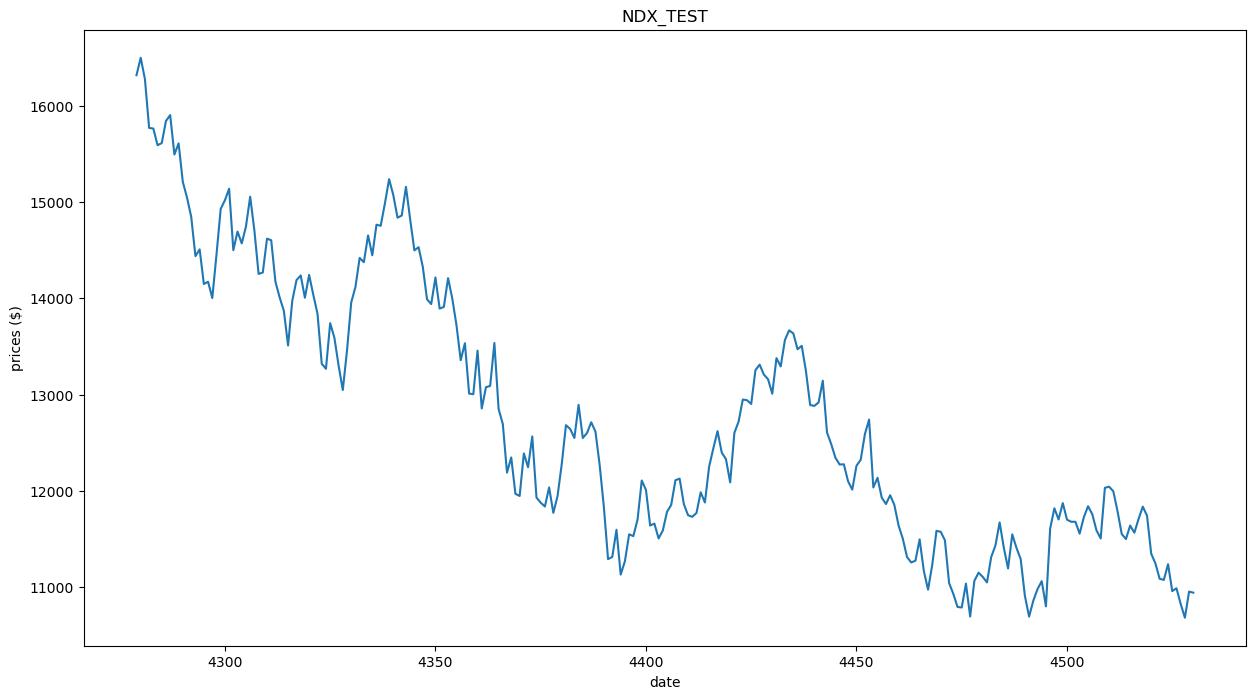

In [6]:
#ราคาปิด
#df_close = df['close']
plt.figure(figsize=(15, 8))
plt.title('NDX_TEST')
plt.plot(df['close'][-252::])
#plt.plot(df_close[:-252:])
plt.xlabel('date')
plt.ylabel('prices ($)')
plt.savefig('NDX_TEST.png')

Text(0, 0.5, 'prices ($)')

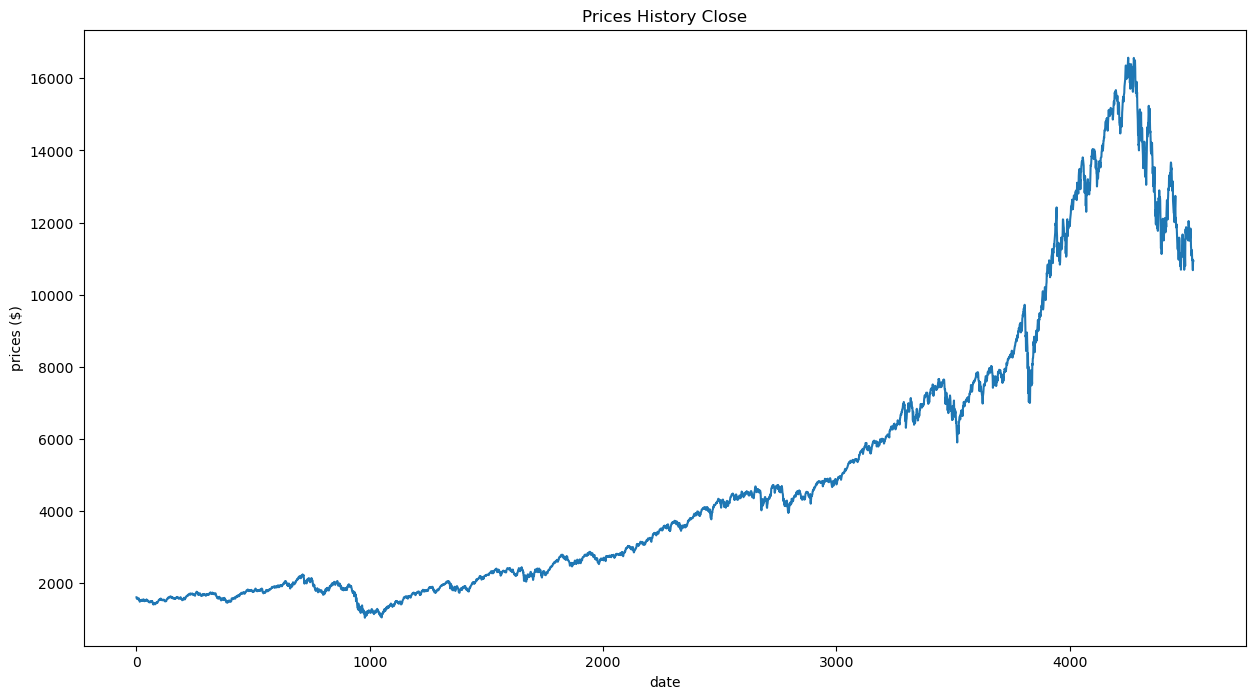

In [7]:
#ราคาปิด
#df_close = df['close']
plt.figure(figsize=(15, 8))
plt.title('Prices History Close')
plt.plot(df['close'])
#plt.plot(df_close[:-252:])
plt.xlabel('date')
plt.ylabel('prices ($)')

In [8]:
print('Samples:', df.shape)
print('Train set:', df[:-252].shape)

Samples: (4531, 12)
Train set: (4279, 12)


In [9]:
#Close
close_prices = df['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* (4279/4531))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]
#y_test = scaled_data[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# GRU
model = Sequential()
step = 60 

model.add(GRU(units=250, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(250 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=200, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(200 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=150, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(150 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=100, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(100 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, input_shape=(step, 1), activation='tanh'))
model.add(Dense(50 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

#model = Sequential(name="GRU-Model") # Model
#model.add(Input(shape=(x_train.shape[1],x_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
#model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
#model.add(RepeatVector(x_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
#model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
#model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

#rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
 #             loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
  #            metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
   #           loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
    #          weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
     #         run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
      #        steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
       #      )
model.summary()

2023-04-28 22:20:50.761251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 250)           189750    
                                                                 
 dense (Dense)               (None, 60, 250)           62750     
                                                                 
 dropout (Dropout)           (None, 60, 250)           0         
                                                                 
 gru_1 (GRU)                 (None, 60, 200)           271200    
                                                                 
 dense_1 (Dense)             (None, 60, 200)           40200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 200)           0         
                                                                 
 gru_2 (GRU)                 (None, 60, 150)           1

In [17]:
# GRU
model = Sequential()
step = 60

#model.add(GRU(units=250, return_sequences=True, input_shape=(step, 1), activation='tanh'))
#model.add(Dense(250 , input_shape=(step, 1), activation='tanh'))
#model.add(Dropout(0.2))
#model.add(GRU(units=200, return_sequences=True, input_shape=(step, 1), activation='tanh'))
#model.add(Dense(200 , input_shape=(step, 1), activation='tanh'))
#model.add(Dropout(0.2))
model.add(GRU(units=150, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(150 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=100, return_sequences=True, input_shape=(step, 1), activation='tanh'))
model.add(Dense(100 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, input_shape=(step, 1), activation='tanh'))
model.add(Dense(50 , input_shape=(step, 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 60, 200)           121800    
                                                                 
 dense_12 (Dense)            (None, 60, 200)           40200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 200)           0         
                                                                 
 gru_11 (GRU)                (None, 60, 150)           158400    
                                                                 
 dense_13 (Dense)            (None, 60, 150)           22650     
                                                                 
 dropout_11 (Dropout)        (None, 60, 150)           0         
                                                                 
 gru_12 (GRU)                (None, 60, 100)          

In [18]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [19]:
history = model.fit(x_train, y_train, batch_size= 256, epochs=3,validation_data=(x_test,y_test), verbose=1) #,callbacks=callbacks_list)

Epoch 1/3
17/17 [==============================] - 12s 504ms/step - loss: 0.0176 - accuracy: 4.7405e-04 - val_loss: 164884256.0000 - val_accuracy: 0.0000e+00
Epoch 2/3
17/17 [==============================] - 8s 448ms/step - loss: 0.0030 - accuracy: 4.7405e-04 - val_loss: 164884896.0000 - val_accuracy: 0.0000e+00
Epoch 3/3
17/17 [==============================] - 8s 482ms/step - loss: 0.0016 - accuracy: 4.7405e-04 - val_loss: 164883568.0000 - val_accuracy: 0.0000e+00


In [20]:
train_mse = model.evaluate(x_train, y_train, verbose=0)
test_mse = model.evaluate(x_test, y_test, verbose=0)
print(train_mse, test_mse)

[0.00012183855869807303, 0.0004740459844470024] [164883568.0, 0.0]


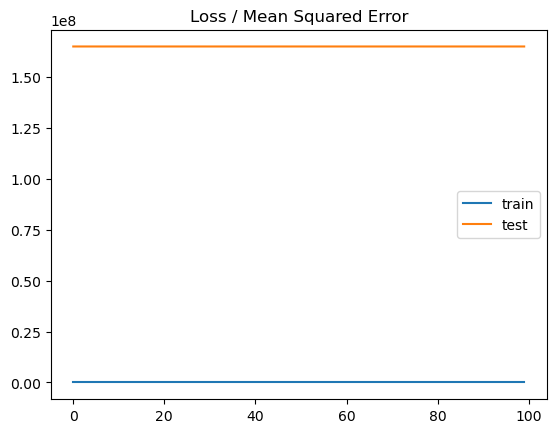

In [101]:
from matplotlib import pyplot
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [81]:
# Load wights file of the best model :
wights_file = 'Weights-088--0.00088.hdf5' # choose the best checkpoint 
model.load_weights(wights_file) # load it
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [102]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 3s 65ms/step


403.9929896763393

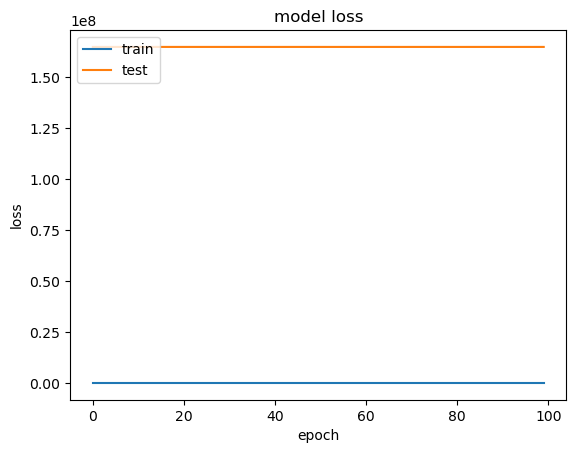

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

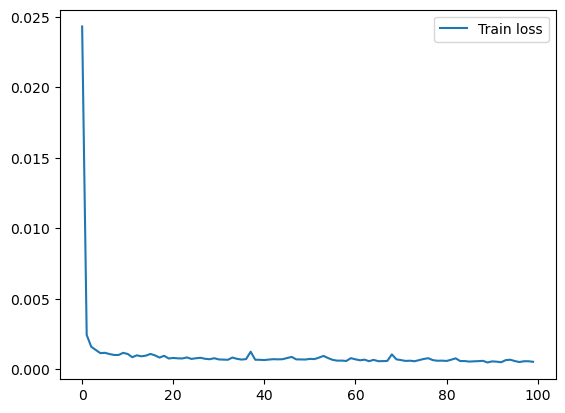

In [104]:
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.show()

In [ ]:
y_test = values[training_data_len:]

In [66]:
predictions

array([[15921.135 ],
       [15927.214 ],
       [15946.585 ],
       [15948.991 ],
       [15898.276 ],
       [15840.119 ],
       [15777.473 ],
       [15725.814 ],
       [15707.793 ],
       [15707.475 ],
       [15670.2   ],
       [15635.195 ],
       [15570.285 ],
       [15487.989 ],
       [15394.173 ],
       [15270.1045],
       [15159.953 ],
       [15035.228 ],
       [14921.463 ],
       [14809.145 ],
       [14754.786 ],
       [14772.34  ],
       [14810.644 ],
       [14851.818 ],
       [14820.155 ],
       [14784.978 ],
       [14746.854 ],
       [14729.492 ],
       [14751.49  ],
       [14745.05  ],
       [14679.94  ],
       [14607.143 ],
       [14582.47  ],
       [14575.298 ],
       [14525.733 ],
       [14449.168 ],
       [14362.659 ],
       [14248.714 ],
       [14188.603 ],
       [14178.944 ],
       [14185.1875],
       [14165.21  ],
       [14159.626 ],
       [14139.117 ],
       [14092.87  ],
       [13990.734 ],
       [13878.436 ],
       [13832

/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_80186/368335215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


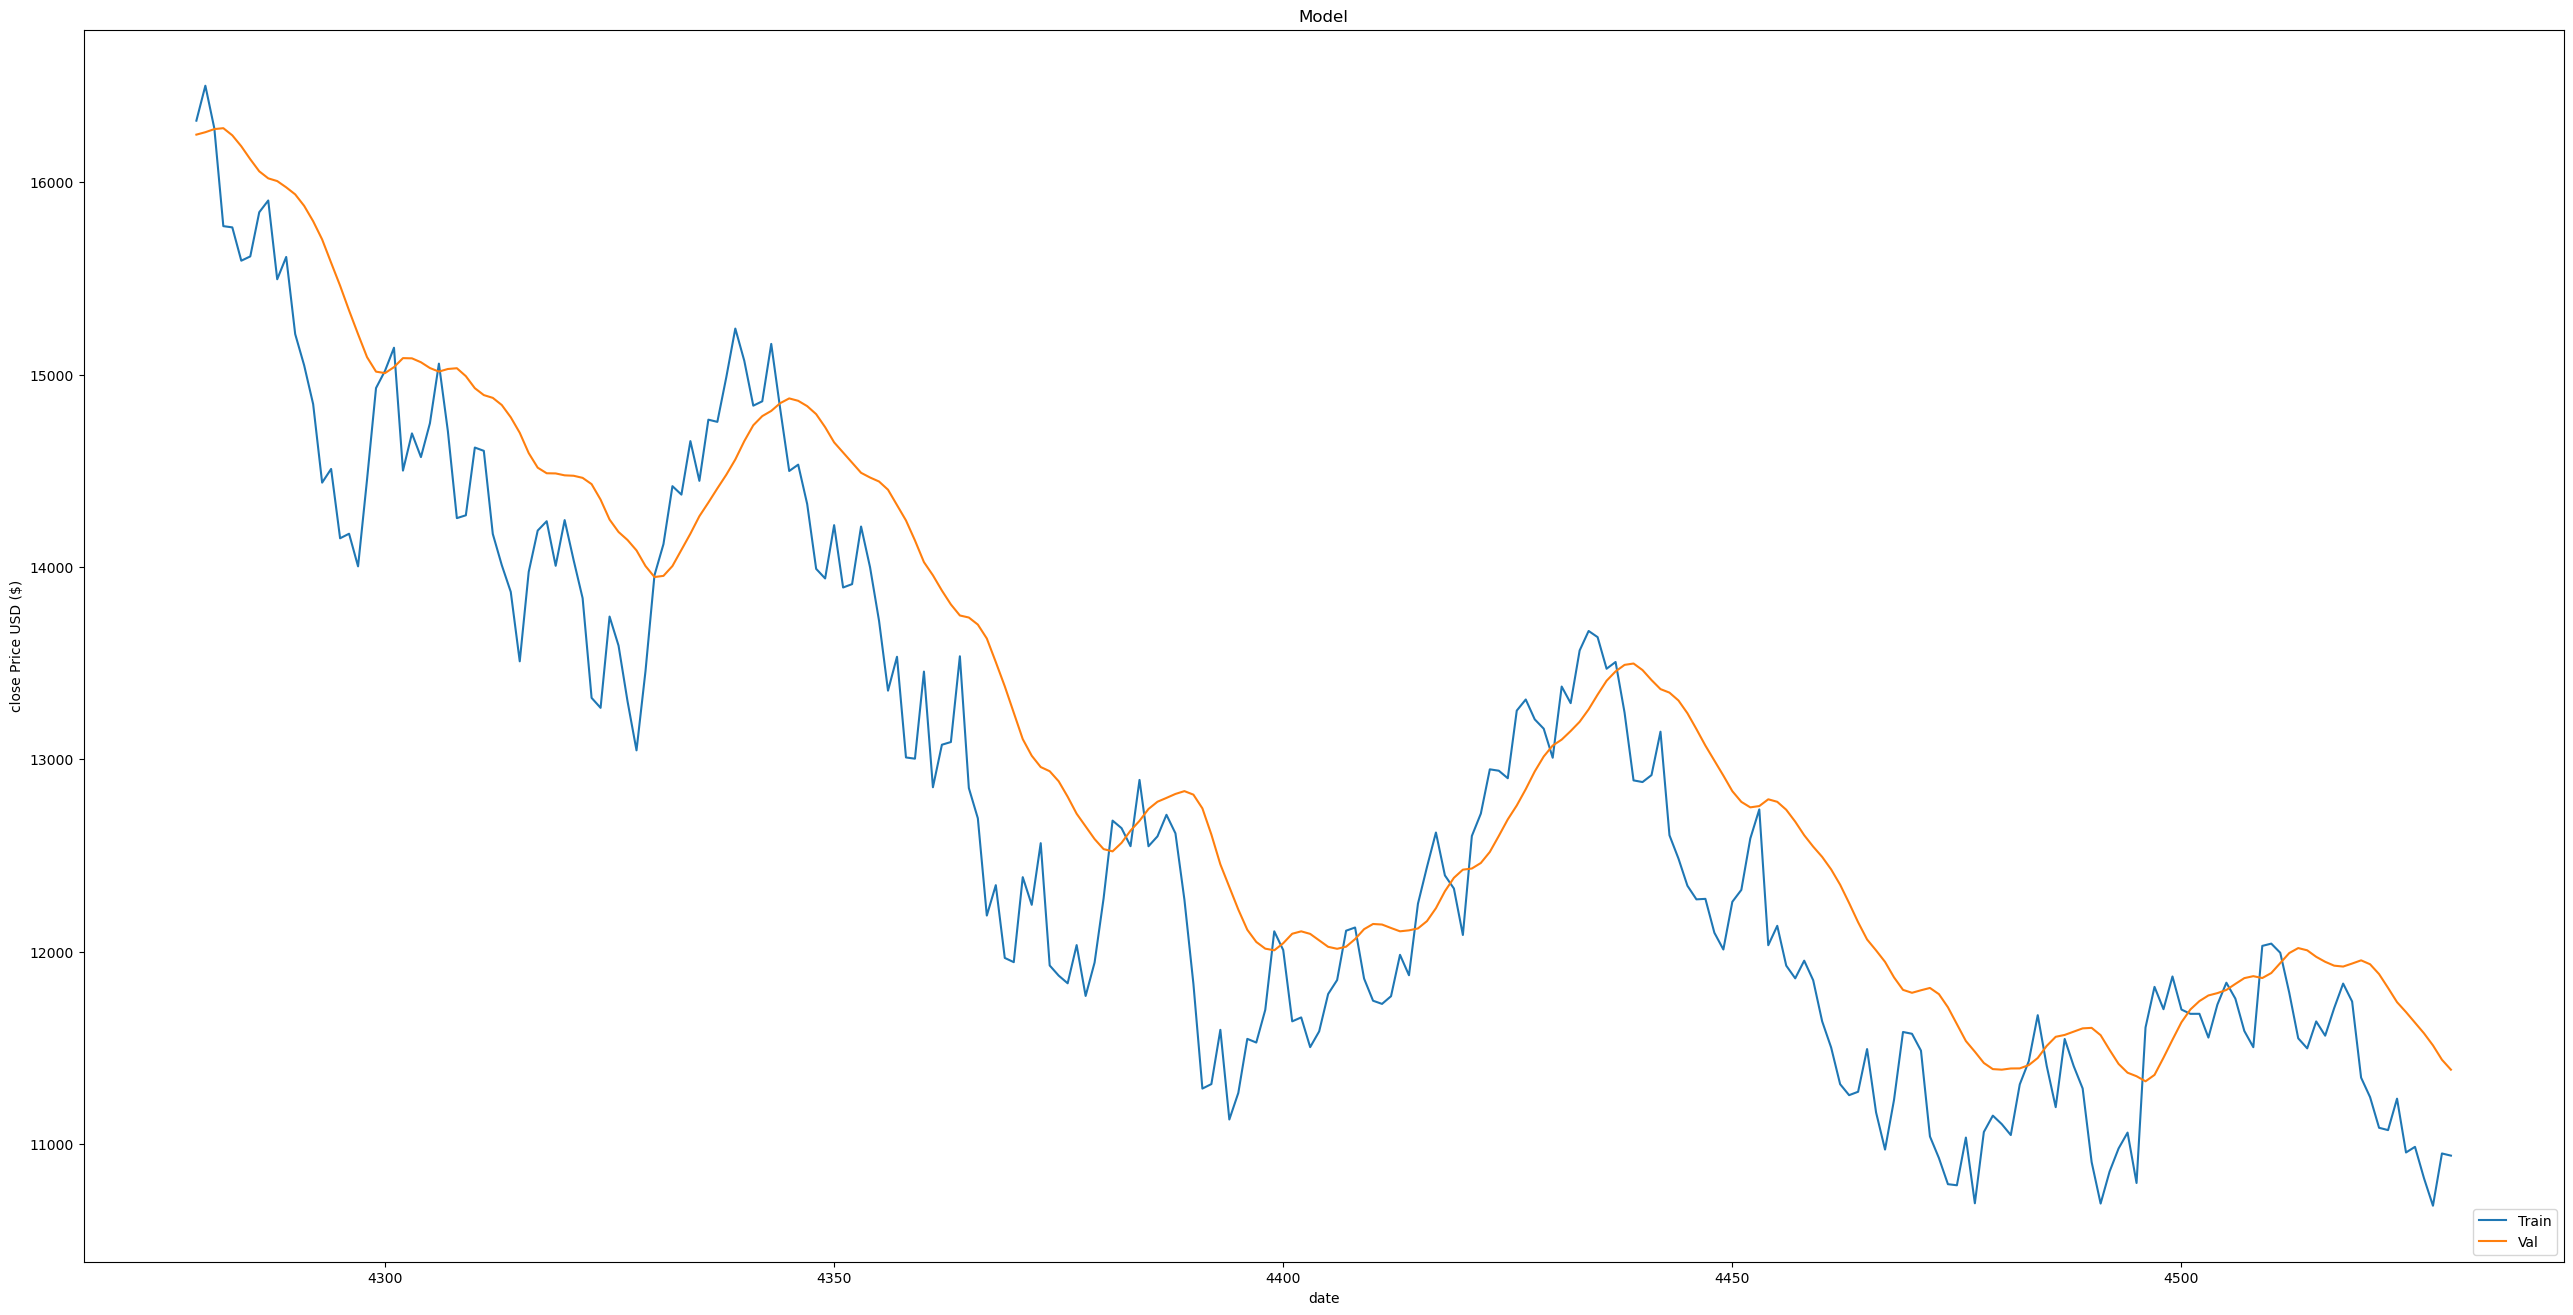

In [106]:
data = df.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(32,16))
plt.title('Model')
plt.xlabel('date')
plt.ylabel('close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
#plt.plot(validation[['Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('Time_Series_Crypto.png')
plt.show()

In [21]:
df_afPredict = df
df_afPredict

,datetime,symbol,open,high,low,close,volume
0,3/1/05,NASDAQ:NDX,1628.75,1635.45,1598.79,1603.51,0
1,4/1/05,NASDAQ:NDX,1611.22,1612.78,1565.02,1571.83,0
2,5/1/05,NASDAQ:NDX,1568.68,1580.88,1562.64,1563.76,0
3,6/1/05,NASDAQ:NDX,1567.66,1570.75,1556.84,1557.52,0
4,7/1/05,NASDAQ:NDX,1565.63,1577.76,1551.29,1564.81,0
...,...,...,...,...,...,...,...
4526,23/12/22,NASDAQ:NDX,10911.04,11007.09,10830.90,10985.45,0
4527,27/12/22,NASDAQ:NDX,10944.30,10957.44,10807.61,10822.51,0
4528,28/12/22,NASDAQ:NDX,10807.12,10898.64,10671.19,10679.34,0
4529,29/12/22,NASDAQ:NDX,10800.80,10981.06,10776.62,10951.05,0


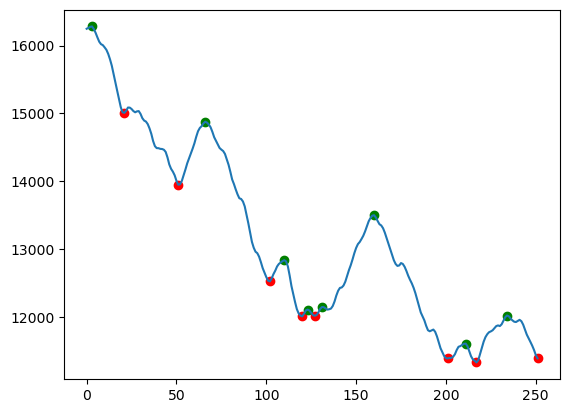

In [121]:
# Generate a noisy AR(1) sample

np.random.seed(0)
#rs = testPredict_inv
#xs = [172.98575]
#rs = np.random.randn(200)
#xs = [0]
#for r in rs:
#    xs.append(xs[-1] * 0.9 + r)
#df = pd.DataFrame(xs, columns=['data'])
df = pd.DataFrame(data = predictions ,columns=['data'] )

n = 5  # number of points to be checked before and after

# Find local peaks

df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal,
                    order=n)[0]]['data']
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal,
                    order=n)[0]]['data']

# Plot results

plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df['data'])
plt.show()

In [24]:
n=0
for i in df['min']:
    if i == List_day_buy[n]:
        df['List_day_buy'][i] = df['min'][i]
        n=n+1
    
df

NameError: name 'List_day_buy' is not defined

In [123]:
#จับคู่แบบที่เอาทุกคู่ที่กว้างที่สุด คือ จุดต่ำสุดที่ n ถึงจุดสูงสุด m ที่มากที่สุดก่อนจะถึงจุดต่ำสุดถัดไป
A_Duo = []
Duo = [-1 , -1]

for i in range(len(df)) :
    if df['max'][i] > 0  and Duo == [-1 , -1]:
        df['max'][i] = 0
    if df['min'][i] > 0 :
        if Duo[0] == -1:
            Duo[0] = df['min'][i]
        elif Duo[0] > 0 and Duo[1] > 0:
            A_Duo.append(Duo)
            Duo = [ df['min'][i] , -1]
            #print(Duo)
        else:
            if Duo[0] > df['min'][i]:
                Duo[0] = df['min'][i]
    if df['max'][i] > 0 :
        if Duo[1] == -1:
            Duo[1] = df['max'][i]
        else:
            if Duo[1] < df['max'][i]:
                Duo[1] = df['max'][i]
    if i == len(df)-1 :
        if Duo[0] > 0 and Duo[1] > 0:
            A_Duo.append(Duo)
        
        #print(df['max'][i])
    #if Duo[0] > 0 and Duo[1] > 0:
     #   A_Duo.append(Duo)
      #  Duo = [-1 , -1]

#print(Duo)
print(A_Duo)

[[13947.611, 14876.246], [12521.487, 12834.663], [12007.059, 12105.748], [12015.027, 13498.071], [11386.6455, 11603.971], [11326.11, 12018.784]]


In [26]:
#จับทุกคู่ที่จับคู่แบบที่เอาทุกคู่ที่กว้างที่สุด คือ จุดต่ำสุดที่ n ถึงจุดสูงสุด m 
#ที่มากที่สุดก่อนจะถึงจุดต่ำสุดถัดไป โดยมีเงื่อนไขคือคู่ระหว่าง n m ต้องมีค่าต่งกัน มากกว่า 5%
A_Duo = []
Duo = [-1,-1]
Num_of_G = [-1,-1]
#A_Num_of_G = []
per = 5
for i in range(len(df)) :
    if df['max'][i] > 0  and Duo == [-1 , -1]:
        df['max'][i] = 0
    if df['min'][i] > 0 :
        if Duo[0] == -1:
            Duo[0] = df['min'][i]
            
            #Num_of_G[0] = i
        elif Duo[0] > 0 and Duo[1] > 0:
            A_Duo.append(Duo)
            #A_Num_of_G.append(Num_of_G)
            Duo = [ df['min'][i] , -1]
            #print(Duo)
            #print(Num_of_G)
        else:
            if Duo[0] > df['min'][i]:
                Duo[0] = df['min'][i]
             #   Num_of_G[0] = i
                
    if df['max'][i] > 0 :
        if Duo[1] == -1:
            if Duo[0]*((100+per)/100) <= df['max'][i]:
                Duo[1] = df['max'][i]
              #  Num_of_G[1] = i
        else:
            if Duo[1] < df['max'][i]:
                Duo[1] = df['max'][i]
               # Num_of_G[1] = i
    if i == len(df)-1 :
        if Duo[0] > 0 and Duo[1] > 0:
            A_Duo.append(Duo)
      #      A_Num_of_G.append(Num_of_G)
        
        #print(df['max'][i])
    #if Duo[0] > 0 and Duo[1] > 0:
     #   A_Duo.append(Duo)
      #  Duo = [-1 , -1]


#print(Duo)
print(A_Duo)
#print(A_Num_of_G)


[[13596.437, 14440.669], [11593.133, 13006.55], [10906.104, 11580.715]]


In [124]:
List_df = df['data'].values.tolist()

In [125]:
List_A_Duo_0

[13596.437, 12134.362, 11611.074, 11593.133, 10976.364, 10906.104]

In [126]:
List_A_Duo_0 = []
List_A_Duo_1 = []
List_day_buy = []
List_day_sell = []
for i in A_Duo:
    List_A_Duo_0.append(i[0])
    List_A_Duo_1.append(i[1])
for i in range (len(List_df)):
    for j in List_A_Duo_0:
        if List_df[i] == j:
            List_day_buy.append(i)
print(List_day_buy)

for i in range (len(List_df)):
    for j in List_A_Duo_1:
        if List_df[i] == j:
            List_day_sell.append(i)
print(List_day_sell)
buy_target = List_A_Duo_0

[51, 102, 120, 127, 201, 217]
[66, 110, 123, 160, 211, 234]


In [127]:
List_X_Y_buy_pair = []
List_X_Y_sell_pair = []
buy_o = []
sell_o =[]
for i in range(len(List_day_buy)) :
    AAAAAAAAAAAAA = [0,0]
    AAAAAAAAAAAAA[0] = List_day_buy[i]
    AAAAAAAAAAAAA[1] = A_Duo[i][0]
    buy_o.append(A_Duo[i][0])
    List_X_Y_buy_pair.append(AAAAAAAAAAAAA)  
print(List_X_Y_buy_pair)

for i in range(len(List_day_sell)) :
    AAAAAAAAAAAAA = [0,0]
    AAAAAAAAAAAAA[0] = List_day_sell[i]
    AAAAAAAAAAAAA[1] = A_Duo[i][1]
    sell_o.append(A_Duo[i][1])
    List_X_Y_sell_pair.append(AAAAAAAAAAAAA)  
print(List_X_Y_sell_pair)
print()
print(buy_o)
print()
print(sell_o)

[[51, 13947.611], [102, 12521.487], [120, 12007.059], [127, 12015.027], [201, 11386.6455], [217, 11326.11]]
[[66, 14876.246], [110, 12834.663], [123, 12105.748], [160, 13498.071], [211, 11603.971], [234, 12018.784]]

[13947.611, 12521.487, 12007.059, 12015.027, 11386.6455, 11326.11]

[14876.246, 12834.663, 12105.748, 13498.071, 11603.971, 12018.784]


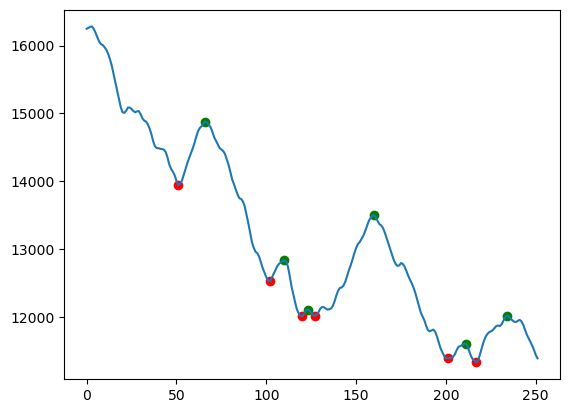

In [128]:
plt.scatter(List_day_buy,buy_o, c='r')
plt.scatter(List_day_sell,sell_o, c='g')
plt.plot(df.index, df['data'])
plt.show()

In [129]:
List_All_day_buy = []
List_All_day_sell = []
for i in range (len(List_day_buy)):
    List_All_day_buy.append(List_day_buy[i]+len(df_train_3))
for i in range (len(List_day_sell)):
    List_All_day_sell.append(List_day_sell[i]+len(df_train_3))
List_All_day_buy

[3826, 3877, 3895, 3902, 3976, 3992]

In [130]:
#ซื้อแบบวัดเปอเซนเท่านั้น
per_stock = []
pair = [-1,-1]
pair_set = []
stock_price_buy = 0
n_List_All_day_buy  = 0
n_List_All_day_sell = 0
for i in range (len(df_close)):
    A = 'null'
    B = 'null'
    C = 'null'
    if i == List_All_day_buy[n_List_All_day_buy]:
        if buy_target[n_List_All_day_buy]*0.9 <= df_close[i] <= buy_target[n_List_All_day_buy]*1.1:
            A = "At " + str(df_datatime[i]+"    BUY:   'NDX'           : " +str(df_close[i]) )
            stock_price_buy = df_close[i]
            print(A)
            pair[0] = df_close[i]
            n_List_All_day_buy = n_List_All_day_buy + 1
            if n_List_All_day_buy == len(List_All_day_buy):
                n_List_All_day_buy = 0
        
#ซื้อตามวัน
    elif stock_price_buy != 0 and i == List_All_day_sell[n_List_All_day_sell]:
        B = "At " + str(df_datatime[i]+"    SELL:  'NDX'           : " +str(df_close[i]) )
        print(B)
        pair[1] = df_close[i]
        pair_set.append(pair)
        pair = [-1,-1]
        n_List_All_day_sell =n_List_All_day_sell + 1
        if n_List_All_day_sell == len(List_All_day_sell):
                n_List_All_day_sell = 0
        stock_price_buy = 0
        
        
    elif df_close[i] < stock_price_buy*0.9:
        C = "At " + str(df_datatime[i]+"    SELL:  'NDX'           : " +str(df_close[i]) )
        print(C)
        pair[1] = df_close[i]
        pair_set.append(pair)
        pair = [-1,-1]
        stock_price_buy = 0
len(per_stock)
print(pair_set)


    

[]


In [109]:
pair_profit = []
All_profit = 0

for i in range (len(pair_set)):
    pair_profit.append(pair_set[i][1] - pair_set[i][0])
print(pair_profit)

for i in pair_profit:
    All_profit = All_profit+i
print(All_profit)
    

[]
0


In [110]:
per_pair_profit = []
All_per_profit = 0

for i in range (len(pair_set)):
    per_pair_profit.append((((pair_set[i][1] - pair_set[i][0])/pair_set[i][0])*100))
print(per_pair_profit)

for i in per_pair_profit:
    All_per_profit = All_per_profit+i
print(str(All_per_profit-(All_per_profit%0.01))+" %")

[]
0.0 %


In [112]:
if df_close[i] < stock_price_buy*0.9:
        B = "At " + str(df_datatime[i])+"    SELL: 'NDX'           : " +str(df_close[i]) 
        print(B)
        stock_price_buy = 0
    elif stock_price_buy != 0 and buy_target(List_All_day_sell[n_List_All_day_sell],df_close)*0.9 <= df_close[List_All_day_sell[n_List_All_day_sell]] <= buy_target(List_All_day_sell[n_List_All_day_sell],df_close)*1.1:
        C = "At " + str(df_datatime[List_All_day_sell[n_List_All_day_sell]]+"    SELL: 'NDX'           : " +str(df_close[List_All_day_sell[n_List_All_day_sell]]) )
        print(C)
        stock_price_buy = 0
        n_List_All_day_sell = n_List_All_day_sell + 1 
    #if A != 'null' and C != 'null':
    #    per[0] = df_close[List_All_day_buy[i]]
    #    per[1] = df_close[List_All_day_sell[i]]
    #    per_stock.append(per)
    #    print(A)
    #    print(B)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [113]:
pair_profit = []
All_profit = 0
for i in range(len(per_stock)):
    pair_profit.append(per_stock[i][1]-per_stock[i][0])
print(pair_profit)

for i in pair_profit:
    All_profit = All_profit + i
print(All_profit)
    

[]
0


In [1]:
per_stock = []
for i in range (len(List_All_day_buy)):
    A = 'null'
    B = 'null'
    per = [-1,-1]
    if buy_target(List_All_day_buy[i],df_close)*0.9 <= df_close[List_All_day_buy[i]] <= buy_target(List_All_day_buy[i],df_close)*1.1:
        A = "At " + str(df_datatime[List_All_day_buy[i]]+"    BUY:  'NDX'           : " +str(df_close[List_All_day_buy[i]]) )
    if buy_target(List_All_day_sell[i],df_close)*0.9 <= df_close[List_All_day_sell[i]] <= buy_target(List_All_day_sell[i],df_close)*1.1:
        B = "At " + str(df_datatime[List_All_day_sell[i]]+"    SELL: 'NDX'           : " +str(df_close[List_All_day_sell[i]]) )
    if A != 'null' and B != 'null':
        per[0] = df_close[List_All_day_buy[i]]
        per[1] = df_close[List_All_day_sell[i]]
        per_stock.append(per)
        print(A)
        print(B)
len(per_stock)

NameError: name 'List_All_day_buy' is not defined

In [115]:
pair_profit = []
All_profit = 0
for i in range(len(per_stock)):
    pair_profit.append(per_stock[i][1]-per_stock[i][0])
#print(pair_profit)

for i in pair_profit:
    All_profit = All_profit + i
print(All_profit)
    
    

0


In [116]:
n = 0 
if buy_target(List_All_day_buy[n],df_close)*0.9 <= df_close[List_All_day_buy[n]] <= buy_target(List_All_day_buy[n],df_close)*1.1:
    print(1)

TypeError: 'list' object is not callable

In [117]:
df_close[List_All_day_buy[0]]

7473.95

In [118]:
for i in range(len(df_close)):
    if i == List_day:
        if (Return_Buy_Target*0.9) <= df_close[i] <= (Return_Buy_Target*1.1):
            A = "BUY : 'NDX' : " +str(df_close[i]) + " at " + str(df_datatime[i]))
        

SyntaxError: unmatched ')' (3960660519.py, line 4)

In [119]:
#จากกรอบเวลทั้งหมดเอรอบใหญ่สุดอันเดียว
A_Duo = []
Duo = [-1 , -1]
Num_of_G = [-1,-1]

for i in range(len(df)) :
    if df['max'][i] > 0  and Duo == [-1 , -1]:
        df['max'][i] = 0
    if df['min'][i] > 0 :
        if Duo[0] == -1:
            Duo[0] = df['min'][i]
            Num_of_G[0] = i
        else:
            if Duo[0] > df['min'][i]:
                Duo[0] = df['min'][i]
                Num_of_G[0] = i
    if df['max'][i] > 0 :
        if Duo[1] == -1:
            Duo[1] = df['max'][i]
            Num_of_G[1] = i
        else:
            if Duo[1] < df['max'][i]:
                Duo[1] = df['max'][i]
                Num_of_G[1] = i
    if i == len(df)-1 :
        if Duo[0] > 0 and Duo[1] > 0:
            A_Duo.append(Duo)
            
        
        #print(df['max'][i])
    #if Duo[0] > 0 and Duo[1] > 0:
     #   A_Duo.append(Duo)
      #  Duo = [-1 , -1]

#print(Duo)
Day = 756
dd = Day - Num_of_G[0]
day_buy = int(Num_of_G[0])
print(A_Duo)
print(Num_of_G)
print(day_buy)

return_buy_target(dd,df_close)

KeyError: 'max'

In [ ]:
def return_buy_target(day,dataframe) :
    dataframe_day = dataframe[-(int(day)):-(int(day)-1):]
    dataframe_list = dataframe_day.values.tolist()
    return (dataframe_list[0])

In [ ]:
def buy_target(day,dataframe):
    dataframe_day = dataframe[day:day+1:]
    dataframe_list = dataframe_day.values.tolist()
    return (dataframe_list[0])

In [ ]:
return_buy_target(dd,df_close)

In [ ]:
def day_buy_target(day_buy,df_train_3):
    db = day_buy
    dataframe_Day = (len(df_train_3))+db
    return dataframe_Day

In [ ]:
Day_Buy_Target = day_buy_target(day_buy,df_train_3)
Return_Buy_Target = return_buy_target(dd,df_close)

In [ ]:
Day_Buy_Target = int(Day_Buy_Target)
Return_Buy_Target = int(Return_Buy_Target)

In [ ]:
df_close[day_buy_target(day_buy,x_train)-1]

In [ ]:
len(df_close)

In [ ]:
for i in range(len(df_close)):
    if i == Day_Buy_Target:
        if (Return_Buy_Target*0.9) <= df_close[i] <= (Return_Buy_Target*1.1):
            print("BUY : 'NDX' : " +str(df_close[i]) + " at " + str(df_datatime[i]))

In [ ]:
A_Duo_list
for i in A_Duo